This notebook aims to investigate the distribution of lightning in the Arctic.

Input:

- monthly OTD lightning data: [LISOTD_HRMC_V2.3.2015.nc](http://dx.doi.org/10.5067/LIS/LIS-OTD/DATA303)
- GLD360 stroke data: gld_stroke_summer.nc and gld-stroke-count-m0p1.csv (generated by [`gld360_summer.py`](https://github.com/zxdawn/S5P-LNO2/blob/main/main/gld360_summer.py))
- 0.5 deg GLD360 strokes inside TROPOMI swaths during the 100 mins before TROPOMI overpass (generated by [`swath_lightning.py`](https://github.com/zxdawn/S5P-LNO2/blob/main/main/swath_lightning.py))

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import proplot as pplt
import cartopy.crs as ccrs
from pyproj import Geod
from functools import lru_cache
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter

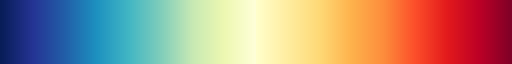

In [2]:
# create colormap
cmap = pplt.Colormap('YlGnBu_r', 'YlOrRd', ratios=(1, 1), name='tropomi_no2')
cmap

## Read data

### OTD monthly lightning density

In [3]:
ds_otd = xr.open_dataset('../data/otd/LISOTD_HRMC_V2.3.2015.nc', decode_times=False)

# Flashes km-2 mon-1
otd_mon = ds_otd.where(ds_otd['Latitude'] > 60, drop=True).sel(Month=slice(6, 8)).mean(dim='Month')['HRMC_COM_FR']*30

### GLD360 summer lightning

#### 0.5 deg area

In [4]:
lon_bnds = np.arange(-180, 180.5, 0.5)
lat_bnds = np.arange(60, 90.5, 0.5)
lon_bounds2d, lat_bounds2d = np.meshgrid(lon_bnds, lat_bnds)

@lru_cache(maxsize=2**10)
def calc_area():
    """Calculate area of each pixel"""
    geod = Geod(ellps="WGS84")

    len_x = lon_bounds2d.shape[0]-1
    len_y = lon_bounds2d.shape[1]-1
    area = np.full((len_x, len_y), 0)

    for x in range(len_x):
        for y in range(len_y):
            # get the corner coordinates
            lons = lon_bounds2d[x:x+2, y:y+2].ravel()
            lats = lat_bounds2d[x:x+2, y:y+2].ravel()

            # clockwise direction
            lons[-2], lons[-1] = lons[-1], lons[-2]
            lats[-2], lats[-1] = lats[-1], lats[-2]

            # get the area
            poly_area, poly_perimeter = geod.polygon_area_perimeter(lons, lats)
            area[x, y] = poly_area

    return xr.DataArray(area, dims=['latitude', 'longitude'],
                        coords={'longitude': lon_bnds[:-1], 'latitude': lat_bnds[:-1]})

area_05deg = calc_area()

In [5]:
# Strokes km-2 mo-1
gld360_summer = xr.open_dataset('../data/gld360/gld_stroke_summer.nc').coarsen(longitude=5, latitude=5).sum().groupby("time.season").mean().sel(season='JJA')/area_05deg.transpose('longitude', 'latitude').values*1e6

# corrected stroke considering the detection efficiency
gld360_summer *= 4

In [6]:
df_lightning = pd.read_csv('../data/gld360/gld-stroke-count-m0p1.csv')
df_lightning.set_index(['time'], inplace=True)
df_lightning.index = pd.to_datetime(df_lightning.index)

# corrected by detection efficiency and IC:CG ratio (~1)
df_lightning['eventCount'] *= 4

# calculate monthly GLD360 strokes in different regions
rule = 'M'
lightning_60 = df_lightning[(df_lightning['latitude'] >= 60)]['eventCount'].resample(rule, label='left', closed='left').sum().reindex(pd.date_range('2019-01-01', '2021-12-31', freq='M'))
lightning_70 = df_lightning[(df_lightning['latitude'] >= 70)]['eventCount'].resample(rule, label='left', closed='left').sum().reindex(pd.date_range('2019-01-01', '2021-12-31', freq='M'))
lightning_80 = df_lightning[(df_lightning['latitude'] >= 80)]['eventCount'].resample(rule, label='left', closed='left').sum().reindex(pd.date_range('2019-01-01', '2021-12-31', freq='M'))

### Lightning within swath 100 min before TROPOMI overpass

In [7]:
ds_swath_0 = xr.open_mfdataset('../data/swath_lightning_crf0*.nc', concat_dim='time', combine='nested')
ds_swath_70 = xr.open_mfdataset('../data/swath_lightning_crf70*.nc', concat_dim='time', combine='nested')
ds_swath_70 = ds_swath_70.where(ds_swath_70['lightning_counts']>100)

# we want to calculate the lightning no matter which CRF condition is
lightning_swath = ds_swath_0['lightning_counts']
# corrected by detection efficiency and IC:CG ratio (~1)
lightning_swath *= 4

In [8]:
lightning_swath_summer = lightning_swath.groupby("time.season").sum().sel(season='JJA')/area_05deg.transpose('longitude', 'latitude').values*1e6/9
lightning_swath_summer.load()

<xarray.DataArray 'lightning_counts' (longitude: 720, latitude: 60)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00263323, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])
Coordinates:
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float64 60.25 60.75 61.25 61.75 ... 88.75 89.25 89.75
    season     <U3 'JJA'

#### Monthly data

In [9]:
# sum data by month
lightning_swath_monthly = lightning_swath.sortby('time').resample(time='1M', closed='left', label='left').sum()

# select the summer season
# note that we use "left" to resample, we should choose the previous months
lightning_swath_monthly = lightning_swath_monthly.where(lightning_swath_monthly['time.month'].isin([5, 6, 7]), drop=True)
lightning_swath_60 = lightning_swath_monthly.where(lightning_swath_monthly['latitude']>60, drop=True).sum(['longitude', 'latitude'])
lightning_swath_70 = lightning_swath_monthly.where(lightning_swath_monthly['latitude']>70, drop=True).sum(['longitude', 'latitude'])
lightning_swath_80 = lightning_swath_monthly.where(lightning_swath_monthly['latitude']>80, drop=True).sum(['longitude', 'latitude'])

lightning_swath_60.load(), lightning_swath_70.load(), lightning_swath_80.load()

time_index = pd.date_range('2019-05-01', '2019-07-31', freq='M').union(pd.date_range('2020-05-01', '2020-07-31', freq='M')).union(pd.date_range('2021-05-01', '2021-07-31', freq='M'))
lightning_swath_60 = lightning_swath_60.reindex({'time': time_index})
lightning_swath_70 = lightning_swath_70.reindex({'time': time_index})
lightning_swath_80 = lightning_swath_80.reindex({'time': time_index})

lightning_swath_percent_60 = ((lightning_swath_60-lightning_swath_70)/(lightning_60-lightning_70).loc[time_index])
lightning_swath_percent_70 = ((lightning_swath_70-lightning_swath_80)/(lightning_70-lightning_80).loc[time_index])
lightning_swath_percent_80 = (lightning_swath_80/lightning_80.loc[time_index])

df_lightning_swath_percent = pd.DataFrame(np.stack((lightning_swath_percent_60, lightning_swath_percent_70, lightning_swath_percent_80)).T,
            index=(time_index+pd.Timedelta('1D')).strftime('%Y-%m'))

## Plot the lightning distribution

In [10]:
def plot_otd(otd_mon, ax, vmax=1):
    m = ax.pcolormesh(otd_mon['Longitude'], otd_mon['Latitude'], otd_mon, cmap=cmap, vmin=0, vmax=vmax, discrete=False,
                     cmap_kw={'left': 0.05, 'right': 0.95})
    ax.colorbar([m], loc='b', extend='max', label='Flash rate (# km$^{-2}$ mo$^{-1}$)')
    ax.format(title='1996-1999')


def plot_lightning_geo(lightning_summer, ax, title, vmax=1):
    """Plot the geo distribution of summed count"""
    lats, lons = np.meshgrid(lightning_summer['latitude'], lightning_summer['longitude'])

    m = ax.pcolormesh(lons, lats, lightning_summer.where(lightning_summer>0),
                      vmin=0, vmax=vmax, extend='max', cmap=cmap, discrete=False,
                      cmap_kw={'left': 0.05, 'right': 0.95})

    ax.colorbar([m], loc='b', label='Stroke rate (# km$^{-2}$ mo$^{-1}$)')
    ax.format(title=title)

/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_9022/2751665745.py:29: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs[:3].stock_img()
/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_9022/2751665745.py:41: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs[:3].text(-42, 66, '70$^{\circ}$ N', rotation=-45, transform=ccrs.PlateCarree())
/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_9022/2751665745.py:42: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs[:3].text(-42, 76, '80$^{\circ}$ N', rotation=-45, transform=ccrs.PlateCarree())


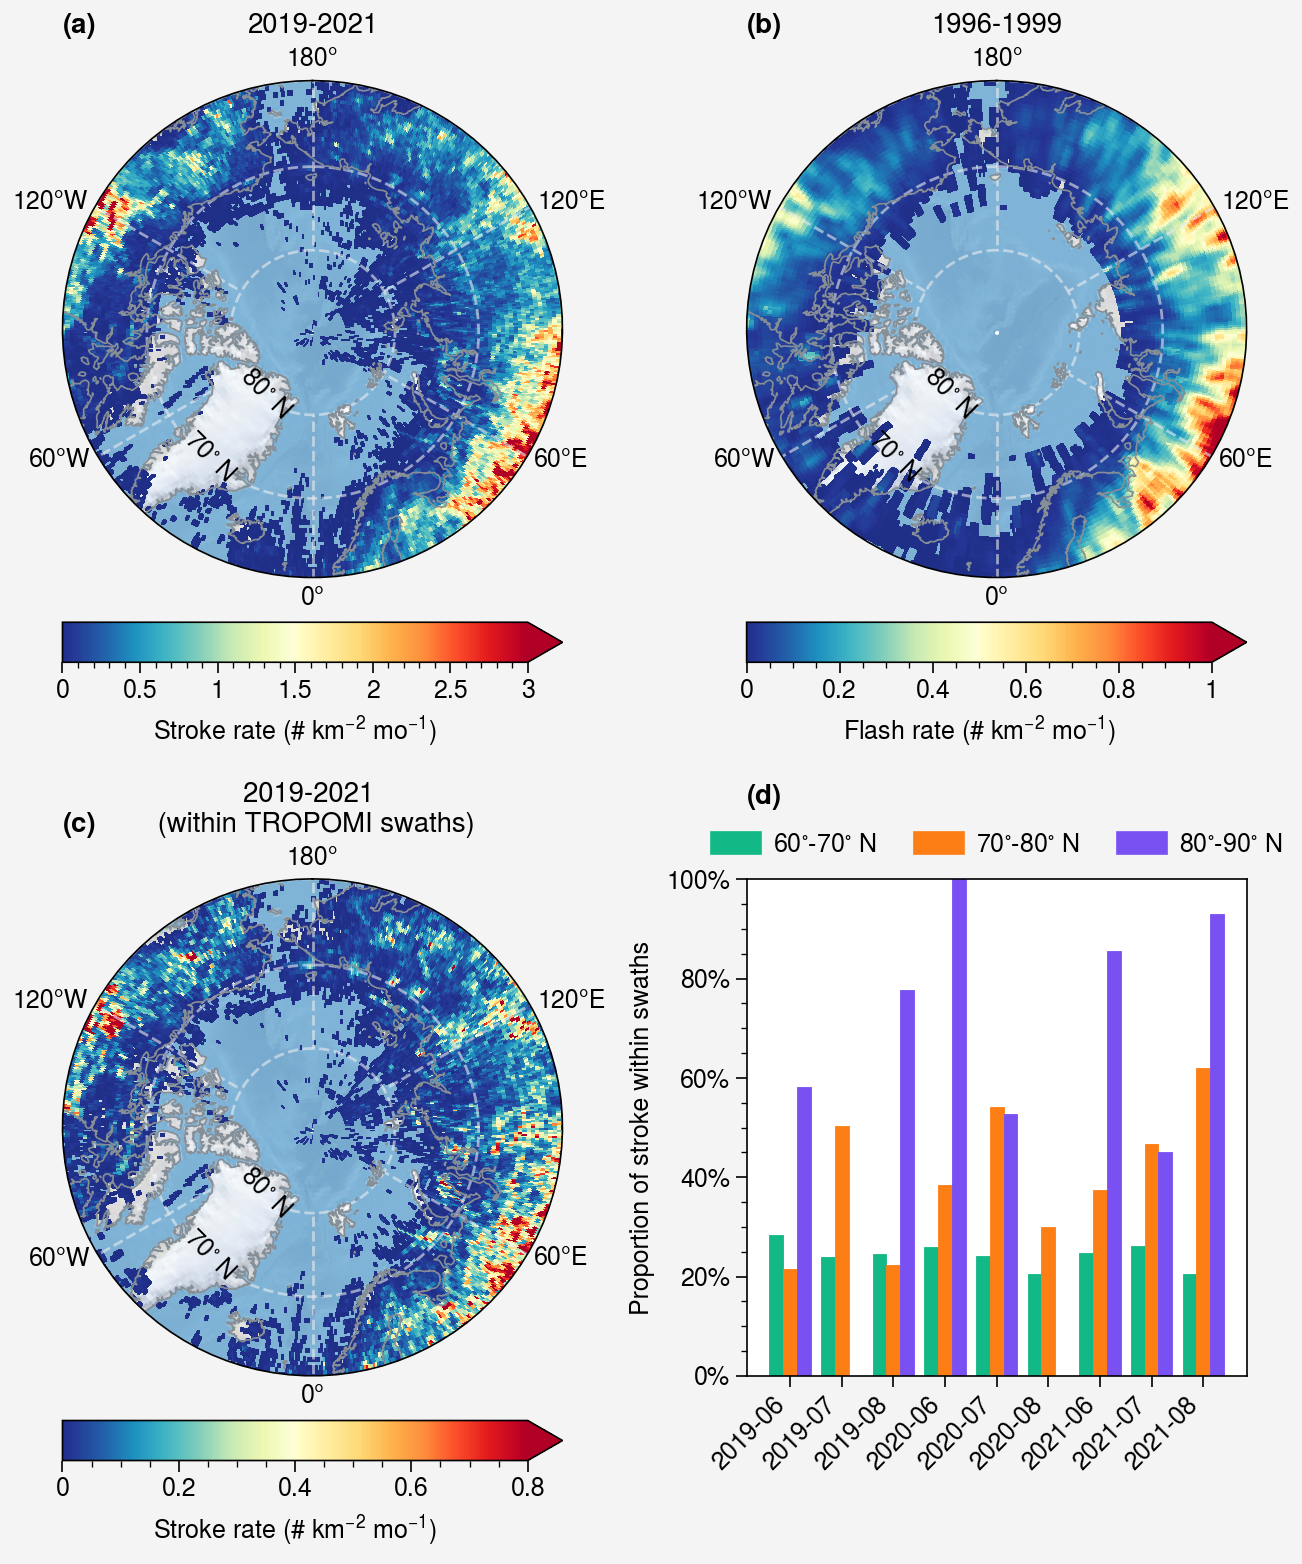

In [11]:
fig, axs = pplt.subplots(nrows=2, ncols=2, proj=['npstere', 'npstere', 'npstere', None])

axs.format(abc='(a)', reso='med', latlines=10, gridcolor='gray2', gridlinewidth=1, gridalpha=0.6, gridlinestyle='--',
           lonlabels='lrbt', landcolor='gray5', coast=True, coastcolor='gray6',
           )

axs[:3].format(boundinglat=60)

plot_lightning_geo(gld360_summer['eventCount'], axs[0], '2019-2021', vmax=3)
plot_otd(otd_mon.sel(Latitude=slice(None, 75)), axs[1])
plot_lightning_geo(lightning_swath_summer, axs[2], '2019-2021 \n (within TROPOMI swaths)', vmax=0.8)

bar = axs[3].bar(df_lightning_swath_percent, cycle=['teal6', 'orange6', 'violet6'])
bar_1 = mpatches.Patch(color='teal6', label='60$^{\circ}$-70$^{\circ}$ N')
bar_2 = mpatches.Patch(color='orange6', label='70$^{\circ}$-80$^{\circ}$ N')
bar_3 = mpatches.Patch(color='violet6', label='80$^{\circ}$-90$^{\circ}$ N')
axs[3].legend(handles=[bar_1, bar_2, bar_3], loc='t', frame=False)


# set percent axis
axs[3].yaxis.set_major_formatter(PercentFormatter(1))
axs[3].format(grid=False, ylim=(0, 1.001), xlabel='', ylabel='Proportion of stroke within swaths')

# rotate xticklabel
for label in axs[3].get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

axs[:3].stock_img()

def map_annotation(lonlat_list, rotate_deg, anno_text):
    l2 = np.array(lonlat_list)
    # Rotate angle
    angle = rotate_deg
    trans_angle = plt.gca().transData.transform_angles(np.array((angle,)),
                                                       l2.reshape((1, 2)))[0]
    plt.text(l2[0], l2[1] , anno_text,
             rotation=trans_angle, rotation_mode='anchor',
             transform=ccrs.PlateCarree())

axs[:3].text(-42, 66, '70$^{\circ}$ N', rotation=-45, transform=ccrs.PlateCarree())
axs[:3].text(-42, 76, '80$^{\circ}$ N', rotation=-45, transform=ccrs.PlateCarree())

fig.savefig('../figures/distribution.png')

(a) Mean GLD360 lightning stroke rate over June–August of 2019–2021;

(b) Mean OTD lightning flash rate over June–August of 1996–1999;

(c) Same as (b) but only counting the lightning inside the TROPOMI swaths during the 6 hour period before the TROPOMI overpass time.
Grids with no lightning are set as transparent in (a)–(c) panels.

(d) The monthly ratio of (c) to (b).